In [ ]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org scikit-posthocs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

# Style configuration
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# 1. Load data
path = 'D:\\Python\\'
scenario_file = os.path.join(path, 'Artigo\\dados_simulacao3.csv')
df_scenarios = pd.read_csv(scenario_file)
df_scenarios.columns = ['Month/Year', 'Scenario CI', 'Scenario CII', 'Scenario CIII']
df_scenarios['Date'] = pd.to_datetime(df_scenarios['Month/Year'], format='%m/%Y')
df_scenarios = df_scenarios[df_scenarios['Date'] <= pd.to_datetime('2034-12-31')]

# 2. Load LSTM predictions
lstm_file = os.path.join(path, 'Artigo\\previsoes_futuras_2025_2035.csv')
df_lstm = pd.read_csv(lstm_file, parse_dates=['Data'])
df_lstm = df_lstm[df_lstm['Data'] <= pd.to_datetime('2034-12-31')]
df_lstm = df_lstm.rename(columns={'Data': 'Date', 'Valor Previsto': 'LSTM'})

# 3. Combine data and calculate annual sums
df_combined = pd.merge(df_scenarios, df_lstm, on='Date', how='left')
df_combined['Year'] = df_combined['Date'].dt.year

# Calculate annual sums
df_annual = df_combined.groupby('Year').sum(numeric_only=True).reset_index()
scenario_period = f"{df_combined['Year'].min()}-{df_combined['Year'].max()}"

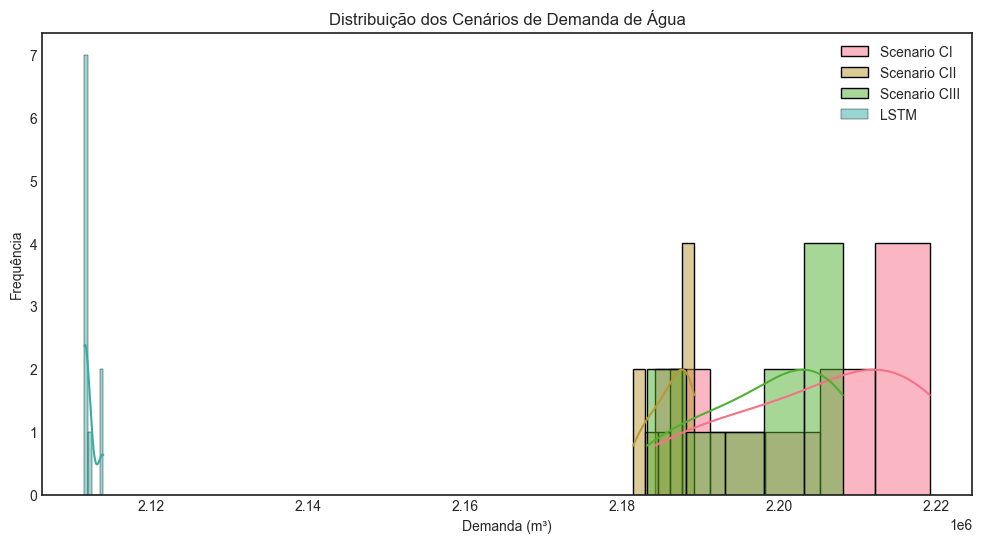

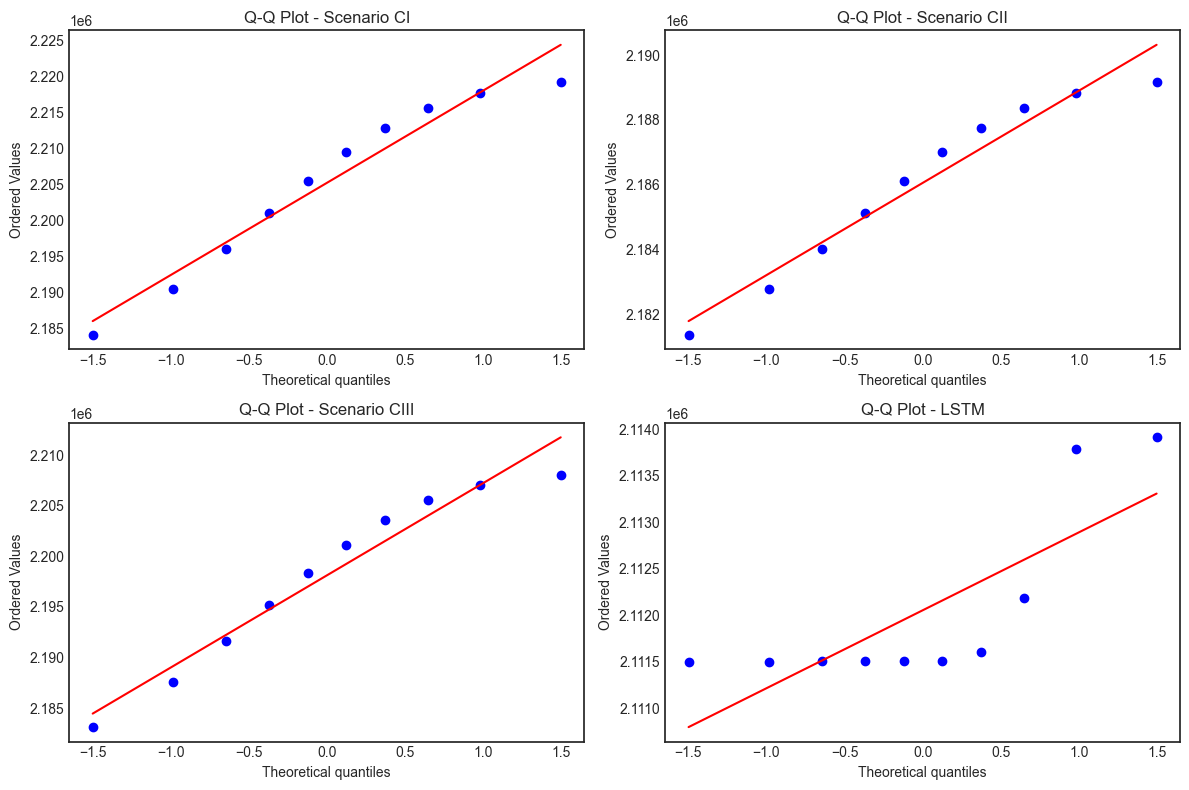

In [2]:
#1. Análise Gráfica (Visual)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for scenario in ['Scenario CI', 'Scenario CII', 'Scenario CIII', 'LSTM']:
    sns.histplot(df_annual[scenario], kde=True, label=scenario)
plt.title('Distribuição dos Cenários de Demanda de Água')
plt.xlabel('Demanda (m³)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

# Q-Q Plot
plt.figure(figsize=(12, 8))
for i, scenario in enumerate(['Scenario CI', 'Scenario CII', 'Scenario CIII', 'LSTM'], 1):
    plt.subplot(2, 2, i)
    stats.probplot(df_annual[scenario], plot=plt)
    plt.title(f'Q-Q Plot - {scenario}')
plt.tight_layout()
plt.show()

In [3]:
#2. Testes de Normalidade Estatísticos

from scipy import stats

normality_results = []
for scenario in ['Scenario CI', 'Scenario CII', 'Scenario CIII', 'LSTM']:
    stat, p = stats.shapiro(df_annual[scenario])
    normality_results.append({
        'Cenário': scenario,
        'Estatística W': stat,
        'p-valor': p,
        'Normal?': 'Sim' if p > 0.05 else 'Não'
    })

normality_df = pd.DataFrame(normality_results)
print("\nTeste de Shapiro-Wilk para Normalidade:")
display(normality_df.round(4))


Teste de Shapiro-Wilk para Normalidade:


,Cenário,Estatística W,p-valor,Normal?
0,Scenario CI,0.9356,0.5052,Sim
1,Scenario CII,0.9356,0.5052,Sim
2,Scenario CIII,0.9356,0.5052,Sim
3,LSTM,0.6207,0.0001,Não


In [4]:
#!pip install scikit-posthocs

In [8]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multitest as multi
import numpy as np

# Criar df_melted (que estava faltando)
df_melted = df_annual.melt(id_vars='Year', 
                          var_name='Scenario', 
                          value_name='Consumption')

# 1. ANOVA para CI/CII/CIII (paramétrico)
print("1. ANÁLISE PARAMÉTRICA (CI/CII/CIII)")
f_val, p_anova = stats.f_oneway(df_annual['Scenario CI'], 
                               df_annual['Scenario CII'], 
                               df_annual['Scenario CIII'])
print(f"ANOVA: F = {f_val:.4f}, p = {p_anova:.4f}")

if p_anova < 0.05:
    print("\n👉 Há diferenças significativas entre CI/CII/CIII (p < 0.05)")
    print("\nTeste Post-Hoc de Tukey:")
    tukey = pairwise_tukeyhsd(
        endog=pd.concat([df_annual['Scenario CI'], 
                        df_annual['Scenario CII'], 
                        df_annual['Scenario CIII']]),
        groups=['CI']*len(df_annual) + ['CII']*len(df_annual) + ['CIII']*len(df_annual),
        alpha=0.05
    )
    print(tukey.summary())
    
    # Verificar quais pares são significativos
    sig_pairs = tukey._results_table.data[1:]  # Ignorar cabeçalho
    sig_pairs = [x for x in sig_pairs if float(x[3]) < 0.05]
    if sig_pairs:
        print("\n🔥 Pares com diferenças significativas:")
        for pair in sig_pairs:
            print(f"- {pair[0]} vs {pair[1]} (p = {float(pair[3]):.4f})")
    else:
        print("\nℹ️ Nenhuma diferença significativa entre pares após correção")
else:
    print("\n👉 Não há diferenças significativas entre CI/CII/CIII (p ≥ 0.05)")

# 2. Kruskal-Wallis para todos (não-paramétrico)
print("\n2. ANÁLISE NÃO-PARAMÉTRICA (INCLUINDO LSTM)")
h_val, p_kw = stats.kruskal(df_annual['Scenario CI'], 
                           df_annual['Scenario CII'], 
                           df_annual['Scenario CIII'],
                           df_annual['LSTM'])
print(f"Kruskal-Wallis: H = {h_val:.4f}, p = {p_kw:.4f}")

if p_kw < 0.05:
    print("\n👉 Há diferenças significativas incluindo LSTM (p < 0.05)")
    
    # Teste Post-Hoc alternativo (Mann-Whitney com Holm)
    print("\nTeste Post-Hoc (Mann-Whitney com correção de Holm):")
    
    scenarios = ['Scenario CI', 'Scenario CII', 'Scenario CIII', 'LSTM']
    comparisons = []
    
    for i in range(len(scenarios)):
        for j in range(i+1, len(scenarios)):
            group1 = scenarios[i]
            group2 = scenarios[j]
            u_stat, p_val = stats.mannwhitneyu(df_annual[group1], df_annual[group2])
            comparisons.append({
                'Grupo A': group1.replace('Scenario ', ''),
                'Grupo B': group2.replace('Scenario ', ''),
                'Estatística U': u_stat,
                'p-valor': p_val
            })
    
    df_comparisons = pd.DataFrame(comparisons)
    # Aplicar correção de Holm
    reject, p_adj, _, _ = multi.multipletests(df_comparisons['p-valor'], method='holm')
    df_comparisons['p-ajustado'] = p_adj
    df_comparisons['Significativo'] = ['Sim' if x else 'Não' for x in reject]
    
    # Mostrar resultados
    display(df_comparisons.round(4))
    
    # Identificar pares significativos
    sig_pairs = df_comparisons[df_comparisons['Significativo'] == 'Sim']
    if not sig_pairs.empty:
        print("\n🔥 Pares com diferenças significativas:")
        for _, row in sig_pairs.iterrows():
            print(f"- {row['Grupo A']} vs {row['Grupo B']} (p-ajustado = {row['p-ajustado']:.4f}, U = {row['Estatística U']:.1f})")
    else:
        print("\nℹ️ Nenhuma diferença significativa entre pares após correção")
else:
    print("\n👉 Não há diferenças significativas incluindo LSTM (p ≥ 0.05)")

# 3. Resumo executivo
print("\n3. RESUMO EXECUTIVO")
print("- Diferenças entre CI/CII/CIII:", "Significativas" if p_anova < 0.05 else "Não significativas")
print("- Diferenças incluindo LSTM:", "Significativas" if p_kw < 0.05 else "Não significativas")

1. ANÁLISE PARAMÉTRICA (CI/CII/CIII)
ANOVA: F = 12.4704, p = 0.0001

👉 Há diferenças significativas entre CI/CII/CIII (p < 0.05)

Teste Post-Hoc de Tukey:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
    CI    CII -19138.6442 0.0001 -28747.4692 -9529.8191   True
    CI   CIII  -7074.4084 0.1805 -16683.2334  2534.4167  False
   CII   CIII  12064.2358 0.0117   2455.4108 21673.0609   True
--------------------------------------------------------------

🔥 Pares com diferenças significativas:
- CI vs CII (p = 0.0001)
- CII vs CIII (p = 0.0117)

2. ANÁLISE NÃO-PARAMÉTRICA (INCLUINDO LSTM)
Kruskal-Wallis: H = 29.8316, p = 0.0000

👉 Há diferenças significativas incluindo LSTM (p < 0.05)

Teste Post-Hoc (Mann-Whitney com correção de Holm):


,Grupo A,Grupo B,Estatística U,p-valor,p-ajustado,Significativo
0,CI,CII,93.0,0.0013,0.0039,Sim
1,CI,CIII,69.0,0.1620,0.1620,Não
2,CI,LSTM,100.0,0.0002,0.0011,Sim
3,CII,CIII,12.0,0.0046,0.0092,Sim
4,CII,LSTM,100.0,0.0002,0.0011,Sim
5,CIII,LSTM,100.0,0.0002,0.0011,Sim



🔥 Pares com diferenças significativas:
- CI vs CII (p-ajustado = 0.0039, U = 93.0)
- CI vs LSTM (p-ajustado = 0.0011, U = 100.0)
- CII vs CIII (p-ajustado = 0.0092, U = 12.0)
- CII vs LSTM (p-ajustado = 0.0011, U = 100.0)
- CIII vs LSTM (p-ajustado = 0.0011, U = 100.0)

3. RESUMO EXECUTIVO
- Diferenças entre CI/CII/CIII: Significativas
- Diferenças incluindo LSTM: Significativas


In [16]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import product
import statsmodels.stats.multitest as multi

# Lista de cenários (usando os nomes exatos das colunas)
cenarios = ['Scenario CI', 'Scenario CII', 'Scenario CIII', 'LSTM']
nomes_curtos = ['CI', 'CII', 'CIII', 'LSTM']  # Nomes para exibição
n = len(cenarios)

# Criar matriz de resultados
matriz = pd.DataFrame(index=nomes_curtos, columns=nomes_curtos, dtype=object)

# Preencher diagonal com valores nulos
np.fill_diagonal(matriz.values, '-')

# Função para formatar resultados
def format_result(test_name, stat, pval):
    stat_fmt = f"{stat:.4f}" if isinstance(stat, (int, float)) else stat
    pval_fmt = f"p = {pval:.4f}" if pval >= 0.001 else "p < 0.001"
    return f"{test_name}\n{stat_fmt}\n{pval_fmt}"

# Preencher comparações
pairs = []
pvals = []
for i, j in product(range(n), range(n)):
    if i >= j:  # Evitar duplicatas
        continue
        
    grupoA = cenarios[i]
    grupoB = cenarios[j]
    nomeA = nomes_curtos[i]
    nomeB = nomes_curtos[j]
    
    # Selecionar teste apropriado
    if 'LSTM' in [grupoA, grupoB]:
        # Teste não-paramétrico
        stat, pval = stats.mannwhitneyu(df_annual[grupoA], df_annual[grupoB])
        test_name = "Mann-Whitney"
    else:
        # Teste paramétrico
        stat, pval = stats.ttest_ind(df_annual[grupoA], df_annual[grupoB])
        test_name = "ANOVA(t-test)"
    
    # Armazenar para correção posterior
    pairs.append((i, j))
    pvals.append(pval)
    
    # Armazenar resultados temporários
    matriz.at[nomeA, nomeB] = (test_name, stat, pval)
    matriz.at[nomeB, nomeA] = (test_name, stat, pval)

# Aplicar correção de Holm
reject, pvals_adj, _, _ = multi.multipletests(pvals, method='holm')

# Atualizar matriz com p-valores ajustados
for (i, j), p_adj in zip(pairs, pvals_adj):
    nomeA = nomes_curtos[i]
    nomeB = nomes_curtos[j]
    test_name, stat, _ = matriz.at[nomeA, nomeB]
    
    # Formatar resultado final
    result = format_result(test_name, stat, p_adj)
    matriz.at[nomeA, nomeB] = result
    matriz.at[nomeB, nomeA] = result

# Estilo para melhor visualização
def highlight_diagonal(val):
    return 'background-color: #f0f0f0' if val == '-' else ''

styled_matriz = matriz.style.applymap(highlight_diagonal)\
                          .set_properties(**{'text-align': 'center', 
                                           'white-space': 'pre-wrap'})\
                          .set_table_styles([{
                              'selector': 'th',
                              'props': [('text-align', 'center')]
                          }])

# Exibir resultados
print("Matriz de Comparações Estatísticas entre Cenários")
print("Cada célula mostra: Teste utilizado\nEstatística\nValor-p (ajustado)")
display(styled_matriz)

# Exportar para LaTeX
print("\nCódigo LaTeX para a matriz:")
print(matriz.style.to_latex(
    hrules=True,
    position_float='centering',
    caption="Matriz de comparações estatísticas entre cenários",
    label="tab:stats_matrix",
    convert_css=True
))

Matriz de Comparações Estatísticas entre Cenários
Cada célula mostra: Teste utilizado
Estatística
Valor-p (ajustado)


C:\Users\e124796\AppData\Local\Temp\ipykernel_34480\2602509634.py:72: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_matriz = matriz.style.applymap(highlight_diagonal)\


,CI,CII,CIII,LSTM
CI,-,ANOVA(t-test) 4.9117 p < 0.001,ANOVA(t-test) 1.5147 p = 0.1472,Mann-Whitney 100.0000 p < 0.001
CII,ANOVA(t-test) 4.9117 p < 0.001,-,ANOVA(t-test) -4.2493 p < 0.001,Mann-Whitney 100.0000 p < 0.001
CIII,ANOVA(t-test) 1.5147 p = 0.1472,ANOVA(t-test) -4.2493 p < 0.001,-,Mann-Whitney 100.0000 p < 0.001
LSTM,Mann-Whitney 100.0000 p < 0.001,Mann-Whitney 100.0000 p < 0.001,Mann-Whitney 100.0000 p < 0.001,-



Código LaTeX para a matriz:
\begin{table}
\centering
\caption{Matriz de comparações estatísticas entre cenários}
\label{tab:stats_matrix}
\begin{tabular}{lllll}
\toprule
 & CI & CII & CIII & LSTM \\
\midrule
CI & - & ANOVA(t-test)
4.9117
p < 0.001 & ANOVA(t-test)
1.5147
p = 0.1472 & Mann-Whitney
100.0000
p < 0.001 \\
CII & ANOVA(t-test)
4.9117
p < 0.001 & - & ANOVA(t-test)
-4.2493
p < 0.001 & Mann-Whitney
100.0000
p < 0.001 \\
CIII & ANOVA(t-test)
1.5147
p = 0.1472 & ANOVA(t-test)
-4.2493
p < 0.001 & - & Mann-Whitney
100.0000
p < 0.001 \\
LSTM & Mann-Whitney
100.0000
p < 0.001 & Mann-Whitney
100.0000
p < 0.001 & Mann-Whitney
100.0000
p < 0.001 & - \\
\bottomrule
\end{tabular}
\end{table}



In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations
import statsmodels.stats.multitest as multi

# Definir cenários
cenarios = ['CI', 'CII', 'CIII', 'LSTM']
n = len(cenarios)

# Criar matriz de resultados
matriz = pd.DataFrame(index=cenarios, columns=cenarios, dtype=object)
np.fill_diagonal(matriz.values, '-')

# Função para formatar resultados
def format_result(test, stat, pval):
    pval_fmt = f"p = {pval:.4f}" if pval >= 0.001 else "p < 0.001"
    return f"{test}\n{stat}\n{pval_fmt}"

# 1. ANOVA e Tukey para CI/CII/CIII
if p_anova < 0.05:
    # Extrair resultados do Tukey corretamente
    tukey_results = pd.DataFrame(data=tukey._results_table.data[1:],
                               columns=tukey._results_table.data[0])
    
    for pair in combinations(['CI', 'CII', 'CIII'], 2):
        # Encontrar o p-valor correspondente
        mask = ((tukey_results['group1'] == pair[0]) & 
                (tukey_results['group2'] == pair[1])) | \
               ((tukey_results['group1'] == pair[1]) & 
                (tukey_results['group2'] == pair[0]))
        
        p_tukey = tukey_results.loc[mask, 'p-adj'].values[0]
        matriz.at[pair[0], pair[1]] = format_result("ANOVA(t-test)", f"F = {f_val:.2f}", p_tukey)
        matriz.at[pair[1], pair[0]] = matriz.at[pair[0], pair[1]]

# 2. Kruskal-Wallis e comparações com LSTM
if p_kw < 0.05:
    for scenario in ['CI', 'CII', 'CIII']:
        # Encontrar o resultado correspondente no df_comparisons
        row = df_comparisons[((df_comparisons['Grupo A'] == scenario) & 
                             (df_comparisons['Grupo B'] == 'LSTM')) |
                            ((df_comparisons['Grupo A'] == 'LSTM') & 
                             (df_comparisons['Grupo B'] == scenario))].iloc[0]
        
        matriz.at[scenario, 'LSTM'] = format_result("Kruskal-Wallis", 
                                                  f"H = {h_val:.2f}", 
                                                  row['p-ajustado'])
        matriz.at['LSTM', scenario] = matriz.at[scenario, 'LSTM']

# Preencher células não testadas
matriz = matriz.fillna("Não aplicável")

# Estilizar a tabela
def style_matrix(val):
    if val == '-':
        return 'background-color: #f7f7f7'
    elif 'Não aplicável' in val:
        return 'color: #999999'
    elif 'p < 0.001' in val:
        return 'font-weight: bold; color: #d62728'
    elif any(f'p = {p:.4f}' in val for p in [0.001, 0.002, 0.003, 0.004, 0.005]):
        return 'font-weight: bold'
    return ''

styled_matrix = matriz.style.applymap(style_matrix)\
                          .set_properties(**{'text-align': 'center',
                                           'white-space': 'pre-wrap',
                                           'min-width': '120px'})

# Exibir resultados
print("MATRIZ DE COMPARAÇÕES ESTATÍSTICAS ENTRE CENÁRIOS")
print("Formato: Teste\nEstatística\nValor-p")
display(styled_matrix)

# Exportar para LaTeX
print("\nCódigo LaTeX para a matriz:")
print(matriz.style.to_latex(hrules=True,
                          position_float='centering',
                          caption="Matriz de comparações estatísticas entre cenários de demanda hídrica",
                          label="tab:stats_matrix",
                          convert_css=True))

MATRIZ DE COMPARAÇÕES ESTATÍSTICAS ENTRE CENÁRIOS
Formato: Teste
Estatística
Valor-p


C:\Users\e124796\AppData\Local\Temp\ipykernel_34480\2325847871.py:66: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_matrix = matriz.style.applymap(style_matrix)\


,CI,CII,CIII,LSTM
CI,-,ANOVA(t-test) F = 12.47 p < 0.001,ANOVA(t-test) F = 12.47 p = 0.1805,Kruskal-Wallis H = 29.83 p = 0.0011
CII,ANOVA(t-test) F = 12.47 p < 0.001,-,ANOVA(t-test) F = 12.47 p = 0.0117,Kruskal-Wallis H = 29.83 p = 0.0011
CIII,ANOVA(t-test) F = 12.47 p = 0.1805,ANOVA(t-test) F = 12.47 p = 0.0117,-,Kruskal-Wallis H = 29.83 p = 0.0011
LSTM,Kruskal-Wallis H = 29.83 p = 0.0011,Kruskal-Wallis H = 29.83 p = 0.0011,Kruskal-Wallis H = 29.83 p = 0.0011,-



Código LaTeX para a matriz:
\begin{table}
\centering
\caption{Matriz de comparações estatísticas entre cenários de demanda hídrica}
\label{tab:stats_matrix}
\begin{tabular}{lllll}
\toprule
 & CI & CII & CIII & LSTM \\
\midrule
CI & - & ANOVA(t-test)
F = 12.47
p < 0.001 & ANOVA(t-test)
F = 12.47
p = 0.1805 & Kruskal-Wallis
H = 29.83
p = 0.0011 \\
CII & ANOVA(t-test)
F = 12.47
p < 0.001 & - & ANOVA(t-test)
F = 12.47
p = 0.0117 & Kruskal-Wallis
H = 29.83
p = 0.0011 \\
CIII & ANOVA(t-test)
F = 12.47
p = 0.1805 & ANOVA(t-test)
F = 12.47
p = 0.0117 & - & Kruskal-Wallis
H = 29.83
p = 0.0011 \\
LSTM & Kruskal-Wallis
H = 29.83
p = 0.0011 & Kruskal-Wallis
H = 29.83
p = 0.0011 & Kruskal-Wallis
H = 29.83
p = 0.0011 & - \\
\bottomrule
\end{tabular}
\end{table}

